In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
#from google.colab import drive
#drive.mount('/content/drive')

In [17]:
#path = '/content/drive/MyDrive/Demographic Predictor Files/UTKFace'
path = "archive/UTKFace"
age_labels = []
gender_labels = []
race_labels = []
image_paths = []

images = os.listdir(path)
random.shuffle(images)

for image in images:
  split = image.split("_")
  if len(split) < 4:
    continue
  image_path = os.path.join(path,image)
  age_label = int(split[0])
  gender_label = int(split[1])
  race_label = int(split[2])

  image_paths.append(image_path)
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  race_labels.append(race_label)

In [18]:
print(f'Age Number: {len(age_labels)}, Gender Number: {len(gender_labels)}, Race Number: {len(race_labels)}, Image_Paths: {len(image_paths)}')

Age Number: 23705, Gender Number: 23705, Race Number: 23705, Image_Paths: 23705


In [19]:
df = pd.DataFrame()
df['image_paths'], df['age'], df['gender'], df['race'] = image_paths, age_labels, gender_labels, race_labels

In [20]:
y_age = np.array(df['age'])
y_gender = np.array(df['gender'])
y_race = np.array(df['race'])

# Data Preprocessing

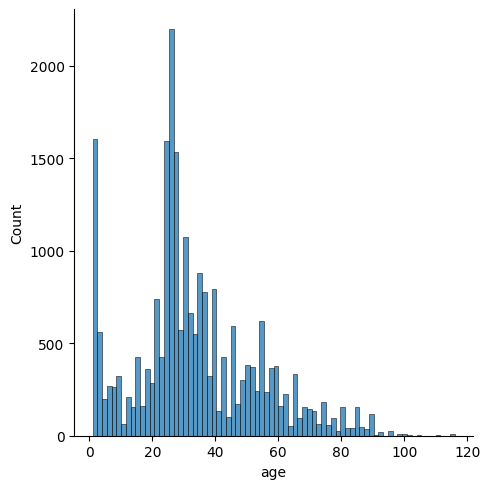

In [21]:
sns.displot(df['age'])

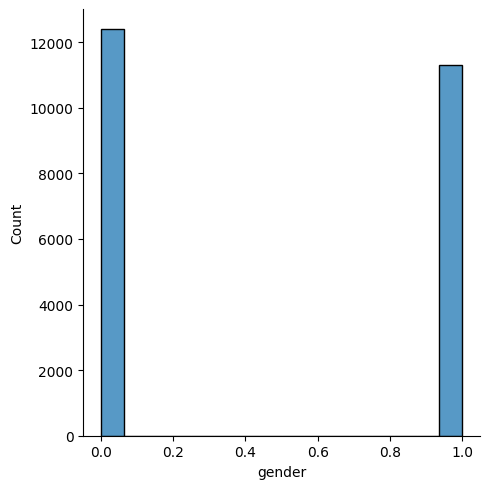

In [22]:
#[gender] is either 0 (male) or 1 (female)
sns.displot(df['gender'])

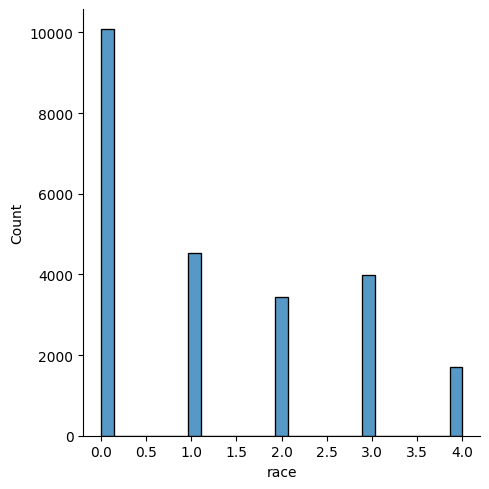

In [23]:
#[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
sns.displot(df['race'])

##### Age is pretty right skewed, gender has more women than men, and race is very imbalanced

# Feature Extraction and Training

In [24]:
def feature_extraction(images):
    features = list()

    for image in images:
        img = load_img(image, color_mode = "grayscale")
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [25]:
X = feature_extraction(df['image_paths'])
X = X / 255.0

In [26]:

input_shape = Input(shape=(128,128,1))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_shape)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# Fully connected layers for age prediction, dropout is added to try to prevent overfitting
dense_age = Dense(256, activation='relu')(flatten)
dropout_age = Dropout(0.3)(dense_age)
output_age = Dense(1, activation='linear', name='age_output')(dropout_age)

# Fully connected layers for gender prediction, dropout is added to try to prevent overfitting
dense_gender = Dense(256, activation='relu')(flatten)
dropout_gender = Dropout(0.3)(dense_gender)
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_gender)

# Fully connected layers for race prediction, dropout is added to try to prevent overfitting
dense_race = Dense(256, activation='relu')(flatten)
dropout_race = Dropout(0.3)(dense_race)
output_race = Dense(5, activation='softmax', name='race_output')(dropout_race)

model = Model(inputs=input_shape, outputs=[output_age, output_gender, output_race])

model.compile(optimizer= 'adam', 
              loss=['mae', 'binary_crossentropy', 'categorical_crossentropy'], 
              metrics={'mae','accuracy','accuracy'})

ValueError: Expected `metrics` argument to be a list, tuple, or dict. Received instead: metrics={'accuracy', 'mae'} of type <class 'set'>

In [ ]:
y_race_encoded = to_categorical(y_race, num_classes=5)
y_race_encoded


array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

In [ ]:
history = model.fit(x=X, y=[y_age, y_gender,y_race_encoded],
                    batch_size=32, epochs=50, validation_split=0.2)

In [29]:
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

# Compute value counts for each output (age, gender, race)
age_counts = df['age'].value_counts()
gender_counts = df['gender'].value_counts()
race_counts = df['race'].value_counts()

# Function to compute class weights for each output
def compute_class_weights(class_counts):
    class_labels = sorted(class_counts.index)  # Ensure labels are sorted
    classes = np.unique(df[class_counts.name])  # Get unique classes from the DataFrame column
    class_weights = compute_class_weight('balanced', classes=classes, y=df[class_counts.name])
    return {cls: weight for cls, weight in zip(class_labels, class_weights)}

# Compute class weights for each output
age_class_weights = compute_class_weights(age_counts)
gender_class_weights = compute_class_weights(gender_counts)
race_class_weights = compute_class_weights(race_counts)

# Optionally normalize class weights (if desired)
def normalize_class_weights(class_weights):
    total = sum(class_weights.values())
    return {cls: weight / total for cls, weight in class_weights.items()}

print("Age Class Weights:", age_class_weights)
print("Gender Class Weights:", gender_class_weights)
print("Race Class Weights:", race_class_weights)
print("\n")
age_class_weights = normalize_class_weights(age_class_weights)
gender_class_weights = normalize_class_weights(gender_class_weights)
race_class_weights = normalize_class_weights(race_class_weights)

print("Age Class Weights:", age_class_weights)
print("Gender Class Weights:", gender_class_weights)
print("Race Class Weights:", race_class_weights)

Age Class Weights: {1: 0.20296766901842592, 2: 0.4728894031279923, 3: 0.7886944370508384, 4: 0.8349182868413637, 5: 1.1629218995290425, 6: 1.7399442160892542, 7: 1.639803541781959, 8: 0.8666642293068149, 9: 1.3730885078776645, 10: 1.4611070019723866, 11: 3.5066568047337277, 12: 1.7533284023668638, 13: 2.8139838556505223, 14: 1.4518005879470848, 15: 1.287755323772273, 16: 0.9228044222983495, 17: 1.442611976630964, 18: 0.8699721080446271, 19: 2.325843799058085, 20: 0.8025799024918743, 21: 0.6587650066696309, 22: 0.5770447906523856, 23: 0.5350532683279162, 24: 0.26534655681919944, 25: 0.31053500314399496, 26: 0.10374724274360142, 27: 0.37062226391494685, 28: 0.24829269314563432, 29: 0.39988191632928477, 30: 0.31482416064598384, 31: 0.6512362637362638, 32: 0.3432721269694161, 33: 1.5939349112426036, 34: 0.5572926462290766, 35: 0.2590144230769231, 36: 0.4719103360407708, 37: 0.7779272775006564, 38: 0.7013313609467455, 39: 0.8601233671988389, 40: 0.43333211465340743, 41: 1.7267628205128205, 

In [ ]:
np.unique(sorted(age_counts.index))

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  95,  96,  99, 100, 101, 103, 105, 110, 111, 115, 116])

In [31]:
import tensorflow as tf

age_weights = tf.constant([age_class_weights[age] for age in sorted(age_class_weights.keys())], dtype=tf.float32)
gender_weights = tf.constant([gender_class_weights[gender] for gender in sorted(gender_class_weights.keys())], dtype=tf.float32)
race_weights = tf.constant([race_class_weights[race] for race in sorted(race_class_weights.keys())], dtype=tf.float32)

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

class WeightedMeanAbsoluteError(tf.keras.losses.Loss):
    def __init__(self, weights, name='weighted_mae'):
        super().__init__(name=name)
        self.weights = tf.constant(weights, dtype=tf.float32)

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  
        mae = tf.abs(y_true - y_pred)

        y_true_clipped = tf.clip_by_value(tf.cast(y_true, tf.int32), 0, len(self.weights) - 1) 

        weights = tf.gather(self.weights, y_true_clipped)  
        weighted_mae = weights * mae
        return tf.reduce_mean(weighted_mae)

class WeightedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(self, weights, name='weighted_binary_crossentropy'):
        super().__init__(name=name)
        self.weights = tf.constant([weights[0], weights[1]], dtype=tf.float32)

    def call(self, y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

        weights = tf.where(tf.equal(y_true, 1), self.weights[1], self.weights[0])
        weighted_bce = weights * bce

        return tf.reduce_mean(weighted_bce)

class WeightedSCCE(tf.keras.losses.Loss):
    def __init__(self, class_weights, from_logits=False, name='weighted_scce'):
        super().__init__(name=name)
        self.class_weights = class_weights
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if y_true.shape[-1] == y_pred.shape[-1]:
            y_true = tf.argmax(y_true, axis=-1)

        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=self.from_logits)

        if self.class_weights is not None:
            weights = tf.gather(self.class_weights, y_true)
            loss *= weights

        return tf.reduce_mean(loss)

input_shape = Input(shape=(128, 128, 1))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_shape)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# Fully connected layers for age prediction
dense_age = Dense(256, activation='relu')(flatten)
dropout_age = Dropout(0.3)(dense_age)
output_age = Dense(1, activation='linear', name='age_output')(dropout_age)

# Fully connected layers for gender prediction
dense_gender = Dense(256, activation='relu')(flatten)
dropout_gender = Dropout(0.3)(dense_gender)
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_gender)

# Fully connected layers for race prediction
dense_race = Dense(256, activation='relu')(flatten)
dropout_race = Dropout(0.3)(dense_race)
output_race = Dense(5, activation='softmax', name='race_output')(dropout_race)  

model = Model(inputs=input_shape, outputs=[output_age, output_gender, output_race])

age_weights = [age_class_weights[age] for age in sorted(age_class_weights.keys())]
gender_weights = [gender_class_weights[0], gender_class_weights[1]]
race_weights = [race_class_weights[i] for i in range(5)]


# Compile model with custom loss functions and class weights
model.compile(optimizer='adam',
              loss={'age_output': WeightedMeanAbsoluteError(age_weights),
                    'gender_output': WeightedBinaryCrossentropy(gender_weights),
                    'race_output': WeightedSCCE(race_weights)},
              metrics={'age_output': 'mae',
                       'gender_output': 'accuracy',
                       'race_output': 'accuracy'})


history = model.fit(x=X, y={'age_output': y_age,
                            'gender_output': y_gender,
                            'race_output': tf.keras.utils.to_categorical(y_race, num_classes=5)},
                    batch_size=32, epochs=50, validation_split=0.2)


Epoch 1/50


ValueError: `labels.shape.rank` must equal `logits.shape.rank - 1`. Received: labels.shape=(None, 1) of rank 2 and logits.shape=(None, 1) of rank 2